In [24]:
#importing packages
import random 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline



from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [25]:
#loading the macroeconomics data 

def get_historical_dataset(interval):

    #S&P NYSE NASDAQ
    tickers = yf.Tickers("^GSPC ^NYA ^IXIC")
    NYA = tickers.tickers["^NYA"].history(start="2014-09-15", end="2022-09-07",interval=interval)
    NYA = NYA[["Open","High","Close","Low","Volume"]]
    NYA = NYA.rename({'Open': 'Open1', 'High': 'High1','Close': 'Close1','Low': 'Low1','Volume': 'Volume1'}, axis=1)
    SEP = tickers.tickers["^GSPC"].history(start="2014-09-15", end="2022-09-07",interval=interval)
    SEP = SEP[["Open","High","Close","Low","Volume"]]
    SEP = SEP.rename({'Open': 'Open2', 'High': 'High2','Close': 'Close2','Low': 'Low2','Volume': 'Volume2'}, axis=1)
    NASDAQ = tickers.tickers["^IXIC"].history(start="2014-09-15", end="2022-09-07",interval=interval)
    NASDAQ = NASDAQ[["Open","High","Close","Low","Volume"]]
    NASDAQ = NASDAQ.rename({'Open': 'Open3', 'High': 'High3','Close': 'Close3','Low': 'Low3','Volume': 'Volume3'}, axis=1) 

    #loading the BTC data
    BTC_Ticker = yf.Ticker("BTC-USD")
    BTC_Data = BTC_Ticker.history(start="2014-09-15", end="2022-09-07",interval = interval)
    BTC_Data = BTC_Data[["Open","High","Close","Low","Volume"]]
    new_dataset = pd.concat([BTC_Data,NYA,SEP,NASDAQ],axis=1)
    return new_dataset

new_dataset = get_historical_dataset("1wk").dropna()

In [26]:
correlation = new_dataset[["Close","Close1","Close2","Close3"]]
correlation= correlation.rename({'Close': 'BTC', 'Close1': 'NYA','Close2': 'SPX','Close3': 'NASDAQ'}, axis=1) 
correlation.corr()

,BTC,NYA,SPX,NASDAQ
BTC,1.000000,0.905751,0.910254,0.918160
NYA,0.905751,1.000000,0.972339,0.945198
SPX,0.910254,0.972339,1.000000,0.988888
NASDAQ,0.918160,0.945198,0.988888,1.000000


In [27]:
#get the close values as a vertical array ( add one more dimension to the array)
#features_array =np.concatenate( (new_dataset.Close.values.reshape(-1,1), new_dataset.Open.values.reshape(-1,1),new_dataset.High.values.reshape(-1,1),new_dataset.Low.values.reshape(-1,1)),axis=1)
features_array = new_dataset.to_numpy()
#close_values=dataframe_close.reshape(-1,1)
#close_values
features_array.shape

(417, 20)

In [28]:
#split the values in train and test
dataset_train = np.array(features_array[:int(features_array.shape[0]*0.8)])
dataset_test = np.array(features_array[int(features_array.shape[0]*0.8):])
dataset_train[0]


array([4.65864014e+02, 4.68174011e+02, 3.98821014e+02, 3.84532013e+02,
       1.56903400e+08, 1.09098496e+04, 1.10605996e+04, 1.09895703e+04,
       1.08810498e+04, 1.72618200e+10, 1.98604004e+03, 2.01926001e+03,
       2.01040002e+03, 1.97847998e+03, 1.72618200e+10, 4.56745020e+03,
       4.61056982e+03, 4.57979004e+03, 4.49987012e+03, 1.05699100e+10])

In [29]:
#normalize the data 
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.fit_transform(dataset_test)



dataset_test

array([[0.29891985, 0.4254457 , 0.42474225, ..., 0.58145986, 0.49247005,
        0.77543144],
       [0.42379553, 0.60312038, 0.63727123, ..., 0.62693728, 0.62923905,
        1.        ],
       [0.63601672, 0.78494514, 0.82833494, ..., 0.58491295, 0.60408734,
        0.58484864],
       ...,
       [0.04833311, 0.0339192 , 0.00707048, ..., 0.25543585, 0.30238414,
        0.4033668 ],
       [0.00687608, 0.00796505, 0.01508101, ..., 0.15829937, 0.18825012,
        0.45389325],
       [0.01495922, 0.        , 0.        , ..., 0.1419562 , 0.17385974,
        0.        ]])

In [30]:
#create dataset with the last (timesteps) prices (x) as with the next movement (y, 1 if price up and 0 if price down)
timesteps = 10
 
def create_dataset2(df):
    x = []
    y = []
    for i in range(timesteps, df.shape[0]):
        x.append(df[i-timesteps:i])
        if(df[i,0]>df[i-1,0]):
            y.append(1)
        else:
            y.append(0)
    x = np.array(x)
    y = np.array(y)
    return x,y

In [31]:
x_train, y_train = create_dataset2(dataset_train)
x_test, y_test = create_dataset2(dataset_test)

count1=0
for i in y_test:
    if i == 1:
        count1+=1

print(count1,len(y_test)-count1,y_test.shape)


35 39 (74,)


In [32]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.

In [33]:
#create a 3D array to use in LTSM layer
#Tensors are the data structure used by machine learning systems, and getting to know them is an essential skill you should build early on.
#LTSM receive 3D tensor

#A tensor is a container for numerical data. It is the way we store the information that we’ll use within our system. [samples, time steps, features]
#The batch size is the size of the training batch you use. It can be anything and doesn't effect the size of the LSTM layer. It just modifies the gradient update step.

#Time steps is the one that determines the size, because it's the number of times that you unroll your LSTM cell. So, that is right, total number of unrolled cells is equal to 5.

#The features is related to the series you want to input/predict. If it is 1, the series is univariate, otherwise it is multi-variate and doesn't have anything to do with the number of cells unrolled.


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_train.shape[2]))


In [34]:

#create the sequence model
def create_model(units,dropout,outputs,features):
    model = Sequential()
#we initialized our model as a sequential one with 96 units in the output’s dimensionality. We used return_sequences=True to make the LSTM layer with three-dimensional input and input_shape to shape our dataset.
#inputs: A 3D tensor with shape [batch, timesteps, feature]
# units : dimensionality of the output space .I think that more units (greater dimension of hidden states) will help the network to remember more complex patterns.The main point is that there is usually no rule for the number of hidden nodes you should use, 
# it is something you have to figure out for each case by trial and error.
#return sequences : Whether to return the last output. in the output sequence, or the full sequence. Default: False .This allows us to have 3D output from hidden LSTM layer as input to the next.
#stateful:  If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
#input_shape = [n_steps,n_features]
    model.add(LSTM(units=units,return_sequences=True, input_shape=(timesteps, features)))
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
#  Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged. Making the dropout fraction 0.2 drops 20% of the layers
# reduce overfitting and improve generalization error in deep neural networks of all kinds.
#One approach to reduce overfitting is to fit all possible different neural networks on the same dataset and to average the predictions from each model. 
# This is not feasible in practice, and can be approximated using a small collection of different models, called an ensemble
# During training, some number of layer outputs are randomly ignored or “dropped out.” 
# This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. 
# In effect, each update to a layer during training is performed with a different “view” of the configured layer.
    model.add(Dropout(dropout))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units,return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
#Finally, we added a dense layer with a value of 1 because we want to output one value.
#The dense layer’s neuron in a model receives output from every neuron of its preceding layer, where neurons of the dense layer perform matrix-vector multiplication.
#dense layer is basically used for changing the dimensions of the vector.
#model.add(Dense(units=units,activation="relu"))
    model.add(Dense(units=outputs,activation="softmax"))
    model.summary()
    return model
#num_params = g × [h(h+i) + h]
#g, no. of FFNNs in a unit (RNN has 1, GRU has 3, LSTM has 4)
#h, size of hidden units (units)
#i, dimension/size of input 

In [35]:
#We used loss='mean_squared_error' because it is a regression problem, and the adam optimizer to update network weights iteratively based on training data.
#The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
#epochs: Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
#batch_size: Number of samples per gradient update.

#variables for test
units = 100
dropout = 0
outputs = y_test.shape[1]
features = x_train.shape[2]

accuracy_list = []
for _ in range(1):
    model = create_model(units,dropout,outputs,features)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=100, batch_size=64)

    loss,accuracy = model.evaluate(x_test, y_test, batch_size=64)
    accuracy_list.append(accuracy)
accuracy_list

#model.get_config()["layers"][1]["config"]
#model.save('stock_prediction.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 100)           48400     
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 100)           80400     
                                                                 
 dropout_2 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               8

[0.5270270109176636]

In [37]:
#getting the signals from the predictions
#TODO test the model varying the timesteps,batch_size,epochs,number of features,number of units,dropout
def create_list_signals2(predictions) :
    buy_sell_signal = []
    for index in range(len(predictions)-1):
        if (abs(predictions[index][0] - predictions[index][1]))<0.1:
            buy_sell_signal.append(0)
        else:
            if predictions[index][0] > predictions[index][1]:
                buy_sell_signal.append(-1)
            if predictions[index][1] > predictions[index][0]:
                buy_sell_signal.append(1)

    return buy_sell_signal

def create_list_signals(predictions) :
    buy_sell_signal = []
    for index in range(len(predictions)-1):
        if predictions[index][0] > predictions[index][1]:
            buy_sell_signal.append(-1)
        if predictions[index][1] > predictions[index][0]:
            buy_sell_signal.append(1)
    return buy_sell_signal


In [38]:
#creating signals from other strategies

def create_random_signals(predictions):
    random_signal = []
    for i in range(len(predictions)-1):
        random_signal.append(random.randint(0,1))
    return random_signal


def create_random_signals(predictions):
    test_dataset = new_dataset[-len(predictions):].reset_index()[["Open","Close"]]
    simple_signal = []
    for index in range(1,len(predictions)):
        if test_dataset.Close[index-1] > test_dataset.Open[index-1]:
            simple_signal.append(1)
        else:
            simple_signal.append(0)
    return simple_signal


In [39]:
#testing the return of investimenting using the signals
def test_signals(buy_sell_signal):
    capital = 100
    capital_list = []
    test_dataset = new_dataset[-len(predictions):].reset_index()[["Open","Close"]]

    for index,signal in enumerate(buy_sell_signal):
        if signal == 1:
            capital = capital/test_dataset.Open[index+1] * test_dataset.Close[index+1]
            capital_list.append(capital)
        elif signal == -1 :
            capital = capital/test_dataset.Close[index+1] * test_dataset.Open[index+1]
            capital_list.append(capital)
        else:
            capital = capital
            capital_list.append(capital)
        
        
    return capital_list




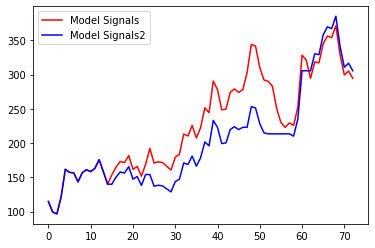

In [40]:
predictions = model.predict(x_test)

capital_list = test_signals(create_list_signals(predictions))
plt.plot(capital_list,'r',label = "Model Signals")
capital_list = test_signals(create_list_signals2(predictions))
plt.plot(capital_list,'b',label = "Model Signals2")
#capital_list = test_signals(random_signal)
#plt.plot(capital_list,'g',label = "Random Signal")
#capital_list = test_signals(simple_signal)
#plt.plot(capital_list,'b',label = "Simple Signal")
plt.legend()

plt.show()



In [41]:
'''from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#calculation of the error metrics in predictions
mae = mae(y_test_scaled,predictions)
mape = mape(y_test_scaled,predictions)
mse = mse(y_test_scaled,predictions)
print(mae,mape,mse)'''

'from sklearn.metrics import mean_absolute_error as mae\nfrom sklearn.metrics import mean_absolute_percentage_error as mape\nfrom sklearn.metrics import mean_squared_error as mse\n#calculation of the error metrics in predictions\nmae = mae(y_test_scaled,predictions)\nmape = mape(y_test_scaled,predictions)\nmse = mse(y_test_scaled,predictions)\nprint(mae,mape,mse)'